In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import iminuit 
from iminuit import Minuit

import mplhep as hep
mpl.style.use(hep.style.ATLAS)

import ROOT

Welcome to JupyROOT 6.24/02


# Everything you've ever wanted to know about fitting*

\*but never had the chance to ask for

I dati presenti nel file `exp.dat` sono dati sperimentali distribuiti secondo una distribuzione sperimentale che segue una PDF come $$ p(t) = \frac{1}{\tau} e^{-t/\tau}.  $$ Realizzeremo il fit di questi dati in diversi modi, partendo inizilmente da un fit ML, passando poi ad una Likelihood binned, e infine ed una Maximum Likelihood Extended Unbinned. 

## TTree

Sono 'contenitori' di dati in formato ROOT, e sono molto utili per effettuare analisi in rapidità su dataset complessi. 

In [2]:
t = ROOT.TTree()
t.ReadFile('exp.txt', 't/D')

1000

In [3]:
exp_data = np.loadtxt('exp.txt', unpack=True)

## Caso Likelihood _unbinned_

In [4]:
def fcn(τ):
    f = 0.0
    for e in exp_data:
        f += np.log(τ) + e/τ
    return f


h = ROOT.TH1D('', '', 40, 0, 10)
for e in exp_data: h.Fill(e)

m1 = Minuit(fcn, τ=2)
m1.errordef = 0.5
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1665                       │              Nfcn = 19               │
│ EDM = 2.29e-09 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ τ    │   1.94    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────┐
│   │       τ │
├───┼─────────┤
│ τ │ 0.00378 │
└───┴─────────┘

In [5]:
hep.histplot(h, histtype='errorbar', color='k', label='Data')
xrange = np.linspace(h.GetXaxis().GetXmin(), h.GetXaxis().GetXmax(), 100)
p = lambda t, τ, N: N*1/τ * np.exp(-t/τ)
plt.plot(xrange, p(xrange, *m1.values, h.GetEntries()*h.GetBinWidth(1)), color='r', label='Fit')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Events')

Text(0, 1, 'Events')

## Caso _binned_ likelihood

È simile al caso che abbiamo già trattato, ma leggermente differente in alcuni particolari
La somma nella definizione di $-\ln\mathcal L$ è sul numero di bin, non __su ogni valore__. Quindi dato $M$ numero di bin, allora $$ p(n_1, \dots, n_M | p_1, \dots, p_M) = \frac{N!}{n_1! \cdot \dots \cdot n_M!} p_1\cdot \dots\cdot p_M,$$ allora la likelihood è definita come $$-\ln \mathcal L (P) = -\sum_{i=1}^{M} n_i \ln(p_i) + \text{const}, $$ dove allora $n_i$ è il numero di entrate del singolo bin, e $$ \ln (p_i) = \ln\left(\int_{x_{\text{min}}}^{x_{\text{max}}} \frac{1}{\tau} e^{-t/\tau}\right) = \ln\left(e^{-\frac{x_{min}}{\tau}} - e^{-\frac{x_{max}}{\tau}}\right).$$

In [13]:

h2 = ROOT.TH1D('', '', 50, 0, 10)
for e in exp_data: h2.Fill(e)

def logL(τ):
    f = 0.0
    for i in range(1, h2.GetNbinsX()+1): ## Il conteggio dei bin parte da 1 e non da zero (retaggi Fortran)
        ni = h2.GetBinContent(i)
        x_min = h2.GetBinLowEdge(i) ## estremo inferiore del bin i-esimo
        x_max = x_min + h2.GetBinWidth(i)
        pi = np.exp(-x_min/τ) - np.exp(-x_max/τ)
        f -= ni*np.log(pi)
    return f

m2 = Minuit(logL, τ=2.0)
m2.errordef = 0.5
m2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3245                       │              Nfcn = 20               │
│ EDM = 1.54e-09 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ τ    │   1.91    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────┐
│   │       τ │
├───┼─────────┤
│ τ │ 0.00367 │
└───┴─────────┘

Text(0, 1, 'Events')

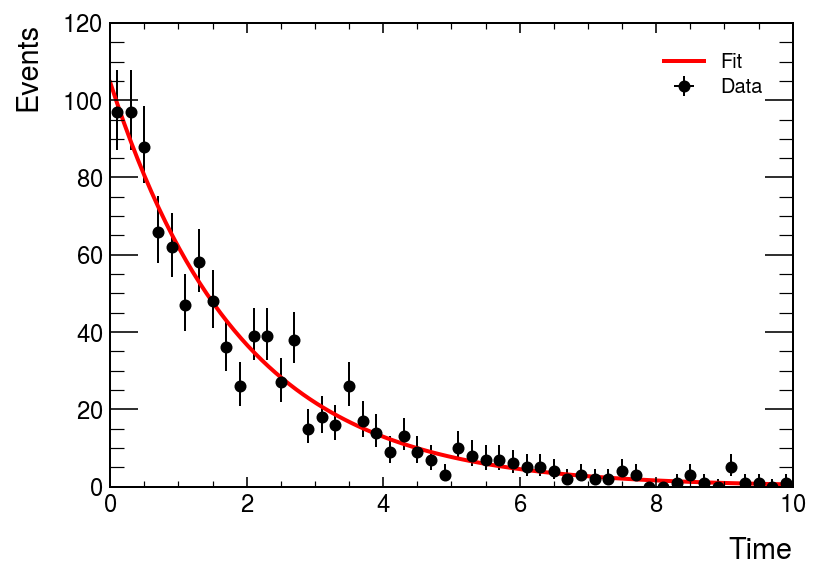

In [14]:
hep.histplot(h2, histtype='errorbar', color='k', label='Data')
xrange = np.linspace(h2.GetXaxis().GetXmin(), h2.GetXaxis().GetXmax(), 100)
p = lambda t, τ, N: N*1/τ * np.exp(-t/τ)
plt.plot(xrange, p(xrange, *m2.values, h2.GetEntries()*h2.GetBinWidth(1)), color='r', label='Fit')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Events')

In [15]:
from uncertainties import ufloat
print(f'τ = {ufloat(m2.values["τ"], m2.errors["τ"]):.3uS} s')

τ = 1.9115(606) s


## Binned Extended Likelihood

La probabilità è fornita come $$ p(n_1, \dots, n_M | p_1, \dots, p_M) = \prod_{i=1}^{M} \frac{e^{-\mu_i}\mu_i^{n_i}}{n_i!},$$ allora la likelihood sarà data come

In [16]:
def logL(τ, normalization):
    f = 0.0
    for i in range(1, h2.GetNbinsX()+1): ## Il conteggio dei bin parte da 1 e non da zero (retaggi Fortran)
        n_i = h2.GetBinContent(i)
        x_min = h2.GetBinLowEdge(i) ## estremo inferiore del bin i-esimo
        x_max = x_min + h2.GetBinWidth(i)
        p_i = np.exp(-x_min/τ) - np.exp(-x_max/τ)
        μ_i = p_i * normalization
        f -= (n_i*np.log(μ_i) - μ_i)
        
    return f

m3 = Minuit(logL, τ=2, normalization=1000)
m3.errordef = 0.5
m3.migrad()



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2641                      │              Nfcn = 33               │
│ EDM = 1.3e-07 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ τ             │   1.98    │   0.07    │            │            │         │         │       │
│ 1 │ normalization │  1.002e3  │  0.032e3  │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────┐
│               │             τ normalization │
├───────────────┼─────────────────────────────┤
│             τ │       0.00469        0.0769 │
│ normalization │        0.0769      1.01e+03 │
└───────────────┴─────────────────────────────┘

In [17]:
for v, e, name in zip(m3.values, m3.errors, ['τ', 'N']):
    print(f'{name} = {ufloat(v,e):.3uS}')

τ = 1.9753(685)
N = 1002.4(31.8)


In [19]:
hep.histplot(h2, histtype='errorbar', color='k', label='Data')
xrange = np.linspace(h2.GetXaxis().GetXmin(), h2.GetXaxis().GetXmax(), 100)
p = lambda t, τ, N: N*1/τ * np.exp(-t/τ)
plt.plot(xrange, p(xrange, *m2.values, h2.GetEntries()*h2.GetBinWidth(1)), color='tab:blue', label='Binned Fit')
plt.plot(xrange, p(xrange, m3.values['τ'], m3.values['normalization']*h2.GetBinWidth(1)), color='r', label='Extended Binned Fit')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('Events')

Text(0, 1, 'Events')